## パラメータ・チューニング（グリッドサーチ）
##### サンプルデータの読み込み
ここではグリッドサーチの実行方法について学びます。<br>
まずはサンプルデータ（分類用）を読み込みます。

グリッドサーチとは、モデルの精度を向上させるために用いられる手法です。全てのパラメータの組み合わせを試してみる方法のことです。イメージとしてはループさせて、パラメータの組み合わせを全て試し、最も評価精度の良いものを探索する方法です。パラメータを変更することで予測精度は飛躍的に変わります。

In [1]:
# Breast cancer dataset for binary classification
import pandas as pd
from sklearn.datasets import load_breast_cancer

# Set X and y
dataset = load_breast_cancer()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.Series(dataset.target, name='y')
X.join(y).head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


##### チューニングするパイプラインの設定
分類器としてロジスティック回帰を設定しておきます。<br>
その際、以下を認識しておきましょう。
- ここでは、学習器の略称として"est"、次元圧縮に"pca"を使います
- 本記号がグリッドサーチ時の設定にも使われます。

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

# パイプラインの設定
pipe_logistic = Pipeline([('scl', StandardScaler()),
                          ('pca', PCA(random_state=1)),
                          ('est', LogisticRegression(solver='lbfgs',random_state=1))])

##### グリッドサーチ条件の設定方法
グリッドサーチによる探索条件の設定は、以下のルールに従います。
- 上記指定の文字列"pca"や"est"と各アルゴリズムが持つパラメータ名の文字列を結合

下記設定例で、具体的に、上記ルールの設定方法を確認しましょう。
- 主成分圧縮：抽出主成分数を5,7,9の3通り
- ロジスティック回帰：正則化パラメータは0.1から100の4通り

In [3]:
# パラメータグリッドの設定方法
param_grid_logistic = {'pca__n_components':[5,7,9],'est__C':[0.1,1.0,10.0,100.0]}

##### グリッドサーチの実行（学習）
ハイパーパラメータの異なるモデルの評価はGridSerachCVで行うことができます。<br>
gsをfitした時点で、各パラメータのモデルの構築と評価を終え、ベストモデルを内部で保持するところまで全自動で動きます。

In [4]:
print('探索空間:%s'%param_grid_logistic)
gs =  GridSearchCV( estimator=pipe_logistic,
                  param_grid=param_grid_logistic,
                  scoring='f1',
                  cv=3,
                  return_train_score=False)
gs.fit(X,y)

探索空間:{'pca__n_components': [5, 7, 9], 'est__C': [0.1, 1.0, 10.0, 100.0]}


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)), ('est', LogisticRegression(C=1.0, class_weight=None, dual=Fals... penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'pca__n_components': [5, 7, 9], 'est__C': [0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

ベストモデルで予測をしたい場合は以下です。

In [5]:
gs.predict_proba(X)

array([[9.99999991e-01, 9.16949126e-09],
       [9.99858219e-01, 1.41781006e-04],
       [9.99999722e-01, 2.78322042e-07],
       ...,
       [9.94479111e-01, 5.52088883e-03],
       [1.00000000e+00, 2.00899844e-11],
       [7.89925108e-06, 9.99992101e-01]])

In [6]:
pd.DataFrame(gs.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_est__C,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.049101,0.041199,0.001527,0.000350,0.1,5,"{'est__C': 0.1, 'pca__n_components': 5}",0.979424,0.975410,0.978903,0.977910,0.001783,5
1,0.005228,0.000141,0.001197,0.000069,0.1,7,"{'est__C': 0.1, 'pca__n_components': 7}",0.983471,0.975410,0.983051,0.980640,0.003707,2
2,0.005734,0.000376,0.001298,0.000168,0.1,9,"{'est__C': 0.1, 'pca__n_components': 9}",0.983471,0.971429,0.983193,0.979358,0.005615,4
3,0.006363,0.000604,0.001479,0.000246,1,5,"{'est__C': 1.0, 'pca__n_components': 5}",0.983333,0.983471,0.974359,0.980398,0.004260,3
4,0.007796,0.001186,0.002042,0.000501,1,7,"{'est__C': 1.0, 'pca__n_components': 7}",0.983333,0.971193,0.974359,0.976299,0.005146,6


## 不均衡データへの対応
まず分類用のサンプルデータであるローン審査データを読み込みます。<br>データ前処理はone-hotエンコーディングと欠損値補完までを行っています。

In [7]:
import pandas as pd
from sklearn.preprocessing import Imputer

# import data
df = pd.read_csv('./data/av_loan_u6lujuX_CVtuZ9i.csv', header=0)
X = df.iloc[:, :-1]          # 最終列外を特徴量X
X = X.drop('Loan_ID',axis=1) # Loan_IDはID情報のため特徴量から削除
y = df.iloc[:,-1]            # 最終列を正解データ

# ローン審査でNOとなったサンプルを1に変換
class_mapping = {'N':1, 'Y':0}
y = y.map(class_mapping)

In [8]:
# one-hot エンコーディング
ohe_columns = ['Dependents',
               'Gender',
               'Married',
               'Education',
               'Self_Employed',
               'Property_Area']

X_ohe = pd.get_dummies(X,
                       dummy_na=True,
                       columns=ohe_columns)

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_ohe)
X_ohe_columns = X_ohe.columns.values
X_ohe = pd.DataFrame(imp.transform(X_ohe), columns=X_ohe_columns)

display(X_ohe.head())

/Users/humu/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Dependents_nan,...,Education_Graduate,Education_Not Graduate,Education_nan,Self_Employed_No,Self_Employed_Yes,Self_Employed_nan,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Property_Area_nan
0,5849.0,0.0,146.412162,360.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4583.0,1508.0,128.000000,360.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3000.0,0.0,66.000000,360.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2583.0,2358.0,120.000000,360.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6000.0,0.0,141.000000,360.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### アンダーサンプリング
アンダーサンプリングの実装例です。<br>負例（422件）が正例の件数（192件）まで削減されていることが確認できます。
<br>分類問題のデータ不均衡による精度影響を変えることができる。<br>アンダーサンプリングとは、<br>少数派のデータ件数に合うように多数派データからランダムに抽出する方法です。

In [9]:
!pip install imblearn
# ランダムアンダーサンプリング
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_under,y_under =  rus.fit_sample(X_ohe,y)
Counter(y_under)

Counter({0: 192, 1: 192})

### オーバーサンプリング
以下、オーバーサンプリングの実装例です。<br>正例（192件）が負例の件数（422件）まで増加していることが確認できます。

In [10]:
# ランダムオーバーサンプリング, SMOTE
from imblearn.over_sampling import RandomOverSampler,SMOTE
ros = RandomOverSampler(random_state=0)
smt = SMOTE(random_state=0)

X_over,y_over = ros.fit_sample(X_ohe, y)
X_smt,y_smt = smt.fit_sample(X_ohe, y)

print('Random Over Sampler',Counter(y_over))
print('SMOTE', Counter(y_smt))

Random Over Sampler Counter({0: 422, 1: 422})
SMOTE Counter({0: 422, 1: 422})


最後に、不均衡対応別のモデルの比較評価の実行例を確認します。<b><br>モデルの評価用データはリサンプリング前に確保されるべきで点に留意しましょう。</b>

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,f1_score

# holdout
X_train,X_test,y_train,y_test= train_test_split(X_ohe,
                                                y,
                                                test_size=0.20,
                                                random_state=0)
# resampling
X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
X_train_over, y_train_over = ros.fit_sample(X_train, y_train)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

# modeling
pipe_gb = Pipeline([('scl',StandardScaler()),
                    ('est',GradientBoostingClassifier(random_state=1))])
# evaluation
###############################################
pipe_gb.fit(X_train,
            y_train)
print('Original Train:', 
      f1_score(y_train,
               pipe_gb.predict(X_train)))
print('Original Test:', 
      f1_score(y_test,
               pipe_gb.predict(X_test)))
###############################################
pipe_gb.fit(X_train_under,
            y_train_under)
print('Undersampling Train:',
      f1_score(y_train_under,
               pipe_gb.predict(X_train_under)))
print('Undersampling Test:', 
      f1_score(y_test,
               pipe_gb.predict(X_test)))
###############################################
pipe_gb.fit(X_train_over,
            y_train_over)
print('Oversampling Train:',
      f1_score(y_train_over,
               pipe_gb.predict(X_train_over)))
print('Oversampling Test:',
      f1_score(y_test,
               pipe_gb.predict(X_test)))
###############################################
pipe_gb.fit(X_train_smt,
            y_train_smt)
print('SMOTE Train:',
      f1_score(y_train_smt,
               pipe_gb.predict(X_train_smt)))
print('SMOTE Test:',
      f1_score(y_test,
               pipe_gb.predict(X_test)))

Original Train: 0.7940074906367042
Original Test: 0.6181818181818182
Undersampling Train: 0.9411764705882353
Undersampling Test: 0.6024096385542169
Oversampling Train: 0.9079365079365079
Oversampling Test: 0.6086956521739131
SMOTE Train: 0.8990228013029316
SMOTE Test: 0.5555555555555556


# モデルの中身を覗く<br>
ここでは変数の重要度の取得方法とPDPの作図法を学びます
##### サンプルデータの読み込み
データはボストン住宅価格データを用います。

In [13]:
import pandas as pd
from sklearn.datasets import load_boston

dataset = load_boston()
X = pd.DataFrame(dataset.data,columns=dataset.feature_names)
y = pd.Series(dataset.target,name='y')
display(X.join(y).head(5))

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


##### モデルの学習
変数の重要度とPDP作図の元となる学習器を構築します。

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

pipe_gbr = Pipeline([('scl',StandardScaler()),
                     ('est',GradientBoostingRegressor(random_state=0))])
pipe_gbr.fit(X,y)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('est', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
        ...e=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])

##### 変数の重要度の取得
変数の重要度を取得するには、`feature_importances_`属性にアクセスします。

In [17]:
imp = pipe_gbr.named_steps['est'].feature_importances_
imp = pd.Series(imp,index=dataset.feature_names)
display(imp)

CRIM       0.025162
ZN         0.000530
INDUS      0.002107
CHAS       0.000873
NOX        0.036577
RM         0.410637
AGE        0.008647
DIS        0.084338
RAD        0.001263
TAX        0.011767
PTRATIO    0.034638
B          0.010558
LSTAT      0.372903
dtype: float64

##### PDP(Partial Dependent Plot)の作図
PDPの作図には以下のパラメータを指定します。
- 学習済みモデル：パイプライン全体ではなく分類/回帰の部分
- PDP作図のためのデータセット：訓練データ
- データセットのカラムリスト（feature_names)
- 作図したい変数（features)

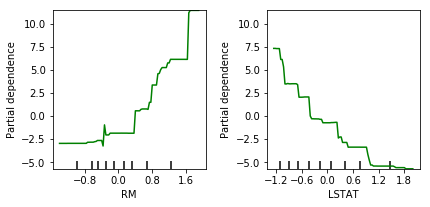

In [23]:

from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt

fig,axs = plot_partial_dependence(pipe_gbr.named_steps['est'],
                                 pipe_gbr.named_steps['scl'].transform(X),
                                 feature_names =  dataset.feature_names,
                                 features=['RM','LSTAT'])
plt.show()

Partial Dependence Plotは、それぞれの特徴量が予測にどのような影響を与えるかを知るのに役に立つ

## SQL使い方(データ確認とクレンジング)
<br>CustomerIDが非NULLのデータを対象に、データ件数、CustomerIDのユニーク件数、InvoiceNoのユニーク件数を確認せよ。

CustomerIDが非NULLのデータを対象に、購買数量（Quantity）と単価（UnitPrice）の最小値・平均値・最大値を確認せよ。

購買数量（Quantity）が負となるケースは注文のキャンセルで生じることがわかった。<br>
キャンセルはInvocieNoが"C"で始まるという。<br>
CustomerIDが非Nullのデータを対象に、以下2つのケースについて数値確認せよ。
1. InvoiceNoが"C"始まりのときの、Qunatityの最小値・平均値・最大値
1. InvoiceNoが"C"始まりでないときの、Qunatityの最小値・平均値・最大値

以下条件の集計クエリを作成しよう。
- クライアントによると現在、半年間における購買回数(InvoiceNoのユニーク数)が4回以上か未満かで、顧客ランクを管理しているという。
- 2011年1月から6月末までの半年間のデータを対象に、顧客ランク別に、顧客数、購買金額(Quantity*Unitprice)、購買回数を集計せよ。
- ただし、CustomerIDが非NULL、UnitPriceが正のデータを対象に行うこと。

サブクエリ

中を入れ子にする( AS data_table必須なのに注意する。subquery in FROM must have an alias)